# Preliminary operations

In [473]:
# Import libraries
import pandas as pd
import numpy as np
import copy
import pickle
import os
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import time

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

# Get environment variables
fail_name = os.environ.get('FAIL', 'driver_strike')
do_train = os.environ.get('TRAIN', 'no')

total_time = 0

In [474]:
%run utils.ipynb

In [475]:
%run preprocessing.ipynb

In [476]:
%run preparation.ipynb

In [477]:
%run training_lstm.ipynb

In [478]:
%run predict.ipynb

In [498]:
# If set to yes, the next cells will retrain the model on training data.
# Otherwise, prediction mode will be set.
fail_name = fail_name
to_train = do_train

# Training

## Preprocessor

In [ ]:
print('--------------------------------')
print('| PREPROCESSOR - TRAINING DATA |')
print('--------------------------------\n')
start = time.perf_counter()

In [500]:
# Read training data
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

In [501]:
df.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

In [502]:
# Save interactive html visualization for training data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: normal</sup>"
save_path = 'html_plots/normal.html'
fig = px.line(df[5400:-1800], x = df[5400:-1800].index, y = df[5400:-1800].columns, title = title) # Delete stabilization time
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [503]:
# List of parameters for preprocessing
params = [
    ['rides_not_served', 'active_customers', 'avg_actual_expected_price_60min', 'avg_actual_price_60min', 'rides_canceled', 'rides_rejections', 'rides_accepted', 'avg_actual_expected_price', 'avg_actual_price', 'avg_actual_expected_price_30min', 'avg_actual_price_30min', 'rides_requested'],
    False, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    1, # differencing
    False, # seasonality
    True # normalize
]
scaler_path = f"df_{len(params[0])}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}"

# Apply preprocessing strategy according to previous parameters selection
df_ = copy.deepcopy(df)
df_proc, scaler = preprocessing(df_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,        # Set to True only for test data, it will load the training scaler
                        save = True)                # Save dataset to datasets/proc
#if to_train == 'yes':
    #print("Preprocessed training data shape: " + str(np.shape(df_proc)))

In [504]:
# Prepare training set for the model
train_set = preparation(df_proc,
                        window_size = 20,  # Windowing for LSTM model
                        overlap = 0,       # Number of observations to overlap for each window. MUST be < window size
                        val_hours = 0)     # Hours to consider for validation set. After cross-validation we use all training data
#if to_train == 'yes':
    #print("Model input training data shape: " + str(train_set.shape))

In [ ]:
finish = time.perf_counter()
print('PREPROCESSOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
total_time += finish - start

## Deep LSTM Autoencoder

In [506]:
# Train autoencoder model with normal data
if to_train == 'yes':
    print('-----------------------------------')
    print('| DEEP LSTM AUTOENCODER - TRAINING|')
    print('-----------------------------------\n')
    start = time.perf_counter()
    history, model = training_lstm(train_set,
                                   None,
                                   n_layers_encoder = 2,
                                   n_layers_decoder = 2,
                                   hidden_units = [128, 64, 32, 32, 64, 128],
                                   activation_hidden = 'tanh',
                                   activation_dense = 'sigmoid',
                                   dropout_rate = 0,
                                   learning_rate = 0.0001,
                                   n_epochs = 500,
                                   metric = 'mse',
                                   batch_size = 32,
                                   window_size = 20,
                                   plot = True,                                   # Save history of training loss
                                   save = True)                                   # Save model to models/lstm
else:
    # Just load the model already trained. Be sure to enter the right path.
    model_path = 'models/lstm/2_2_128_128_tanh_sigmoid_0_00001_500_mse_32.pkl'
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

In [507]:
if do_train == 'yes':
    finish = time.perf_counter()
    print('DEEP LSTM AUTOENCODER execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
    total_time += finish - start

## Predictor

In [508]:
if do_train == 'yes':
    print('-----------------------------')
    print('| PREDICTOR - TRAINING DATA |')
    print('-----------------------------\n')
    start = time.perf_counter()

In [509]:
if to_train == 'yes':
    # Predict and assess performance on training set
    original, reconstructed = predict(model, train_set, scaler_path, recurrent = True)
    
    # Save metrics plots and dataframes
    num_features = min(train_set.shape[2], len(df_proc.columns))
    mae, mse, mape = save_predict_plots(original, reconstructed, df_proc.columns, num_features, scaler_path, model_type = 'lstm', plot = False, compute_df = True)

    # Plot training set reconstruction performance
    for column in range(0, len(df_proc.columns)):
        plt.figure(figsize = (10, 6))
        plt.plot(original[:, column], label = 'Original Features')
        plt.plot(reconstructed[:, column], label = 'Reconstructed Features', linestyle='--')
        plt.title(df_proc.columns[column])
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.legend()
        #plt.show()
        plt.close()
        

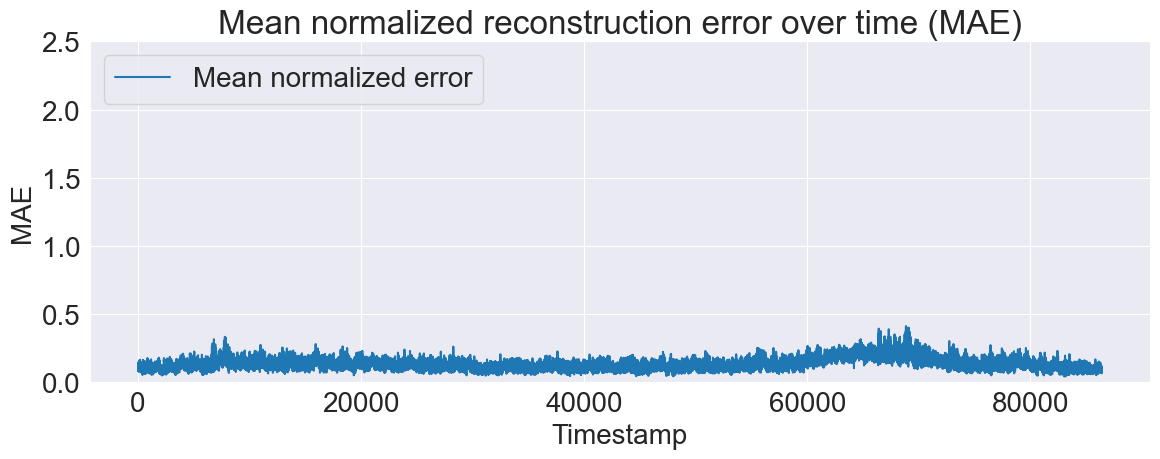

In [510]:
# Load metrics training dataset
mae_df = pd.read_csv("predictions/lstm/lstm_mae.csv")
mse_df = pd.read_csv("predictions/lstm/lstm_mse.csv")
mape_df = pd.read_csv("predictions/lstm/lstm_mape.csv")

# Compute mean mae and mse across columns on training set
mean_err_mae_norm = (mae_df - mae_df.min())/(mae_df.max() - mae_df.min())
mean_err_mae_norm = mean_err_mae_norm.mean(axis = 1)
#mean_err_mse = mse_df.mean(axis = 1)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams.update({'font.size': 20})
plt.plot(mean_err_mae_norm, label = 'Mean normalized error')
#plt.plot(mean_err_mse, color = 'b', label = 'MSE')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.ylim([0, 2.5])
plt.tight_layout()
plt.savefig('results/normal_MAE_lstm.png', dpi = 300)
#plt.show()
plt.close()

In [511]:
#print(mean_err_mae_norm.min())
#print(mean_err_mae_norm.max())
#print(mean_err_mae_norm.idxmax())

In [512]:
if do_train == 'yes':
    finish = time.perf_counter()
    print('PREDICTOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
    total_time += finish - start

# Event

## Preprocessor

We compute the timestamp of the (possible) failure.

In [ ]:
print('-----------------------------')
print('| PREPROCESSOR - EVENT DATA |')
print('-----------------------------\n')
start = time.perf_counter()

In [514]:
# Fail name and hour of the day (currently only "day", i.e., noon)
fail = fail_name
hour = 'day'

In [515]:
# Read event data
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [516]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df_fail.columns:
    df_fail[column] = np.around(df_fail[column].astype(float), 5)
    df_fail[column] = df_fail[column].rolling(window = 300).mean()
df_fail = df_fail[6899:-1800].reset_index(drop = True)

In [517]:
# Define the values for x1, x2 and their corresponding y values
x1, y1 = 0, 0
x2, y2 = df['rides_requested'][6899:-1800].mean(), 1 # Scaling factor = 1 when rides requested >= mean
# Adjust  b to ensure the function is defined at x = 0
b = 0.1
# Values of ln(x+b) at x1 and x2
ln_x1_b = np.log(x1 + b)
ln_x2_b = np.log(x2 + b)
# System of equations:
# a * ln(0.1) + c = 0
# a * ln(df['rides_requested'].mean()) + c = 1
# We can represent this system as matrix equations A * [a, c] = Y
A = np.array([
    [ln_x1_b, 1],
    [ln_x2_b, 1]
])
Y = np.array([y1, y2])
# Solve for coefficients a and c
coefficients = np.linalg.solve(A, Y)
a, c = coefficients

In [518]:
# Compute failed_requests index
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
factor = df['rides_requested'][6899:-1800].mean()
for column in df.columns:
    df[column] = np.around(df[column].astype(float), 5)
    df[column] = df[column].rolling(window = 300).mean()
df = df[6899:-1800].reset_index(drop = True)
failed_requests_train = [0] * len(df)
w_failed_requests_train = [0] * len(df)
for i in range(0, len(df)):
    failed_train, w_failed_train = compute_failed_requests(df['rides_not_served'][i], df['rides_requested'][i], factor, a, b, c)
    failed_requests_train[i] = failed_train
    w_failed_requests_train[i] = w_failed_train
combined_failed_requests_train = pd.Series(failed_requests_train)
w_combined_failed_requests_train = pd.Series(w_failed_requests_train)
failed_requests_fail = [0] * len(df_fail)
w_failed_requests_fail = [0] * len(df_fail)
factor = df['rides_requested'].mean()
for i in range(0, len(df_fail)):
    failed, w_failed = compute_failed_requests(df_fail['rides_not_served'][i], df_fail['rides_requested'][i], factor, a, b, c)
    failed_requests_fail[i] = failed
    w_failed_requests_fail[i] = w_failed

In [519]:
# By calling the function compute_thresholds, the code automatically compute the following thresholds.
perc_95, perc_97, perc_99 = compute_thresholds(combined_failed_requests_train, weight = False)
w_perc_95, w_perc_97, w_perc_99_t = compute_thresholds(w_combined_failed_requests_train, weight = True)

# Compute timestamps exceeding the thresholds
combined_failed_requests = pd.Series(failed_requests_fail)
w_combined_failed_requests = pd.Series(w_failed_requests_fail)
exceed_timestamps = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
w_exceed_timestamps = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
# Need to define interval sliding window where to look for exceeding timestamps, and % of exceeding timestamps needed to call a failure.
exceed_timestamps = exceed_thresholds(combined_failed_requests, exceed_timestamps, 1800, 0.95, perc_95, perc_97, perc_99)
w_exceed_timestamps = exceed_thresholds(w_combined_failed_requests, w_exceed_timestamps, 1800, 0.95, w_perc_95, w_perc_97, w_perc_99_t)

In [520]:
w_exceed_timestamps

{'perc_95': 5758, 'perc_97': 5786, 'perc_99': 5833}

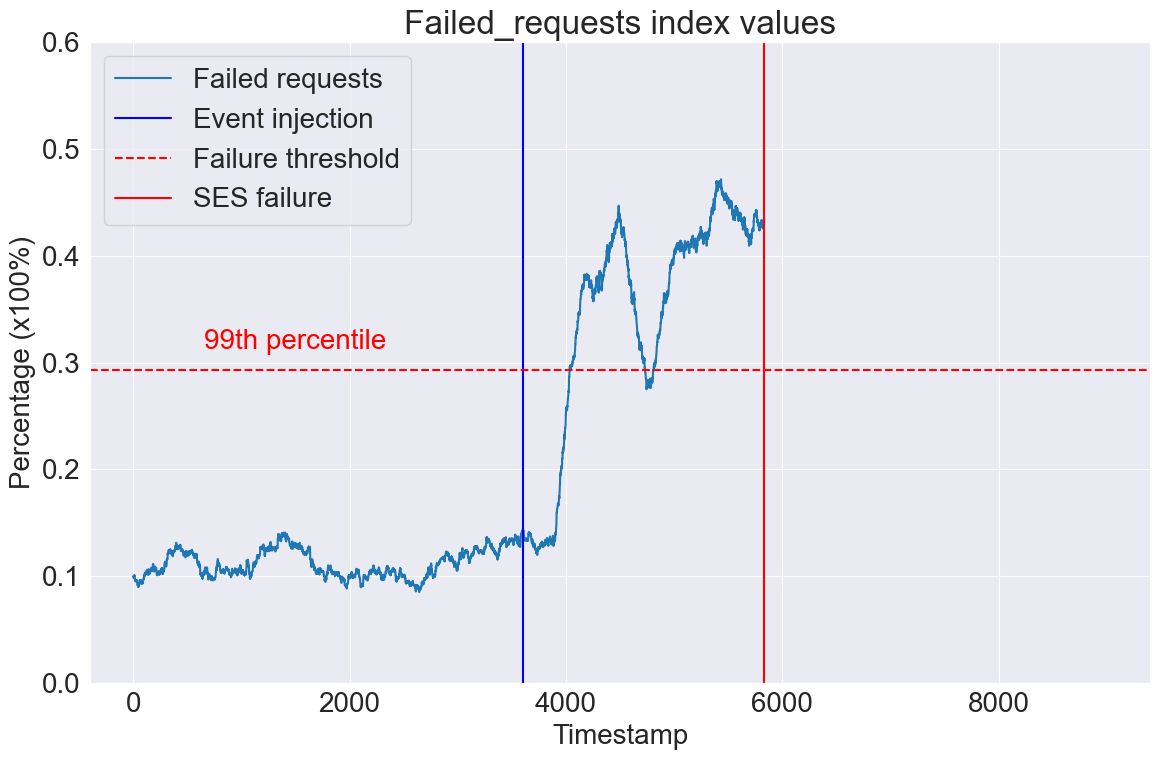

Failed_requests index saved to failed_requests/ directory



In [521]:
# Plot failed_requests index

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 20})

perc_95 = exceed_timestamps.get('perc_95', 0)
perc_97 = exceed_timestamps.get('perc_97', 0)
perc_99 = exceed_timestamps.get('perc_99', 0)
w_perc_95 = w_exceed_timestamps.get('perc_95', 0)
w_perc_97 = w_exceed_timestamps.get('perc_97', 0)
w_perc_99 = w_exceed_timestamps.get('perc_99', 0)
#plt.plot(combined_failed_requests, color = 'b')
w_combined_failed_requests = w_combined_failed_requests[:9000]
if 'greedy' in fail and fail != 'progressive_greedy':
    x_range = np.arange(len(w_combined_failed_requests))
    masked_failed_requests = np.where(x_range <= w_perc_99, w_combined_failed_requests, np.nan)
    plt.plot(x_range, masked_failed_requests, label='Failed requests')
else:
    plt.plot(w_combined_failed_requests, label='Failed requests')
plt.title('Failed_requests index values')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = w_perc_99_t, color = 'red', linestyle='--', label = 'Failure threshold')
plt.annotate(f'99th percentile', xy = (1500, w_perc_99_t),
             xytext = (1500, w_perc_99_t + 0.02),
             horizontalalignment = 'center', color = 'r')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='SES failure')
#max_value = combined_failed_requests.max()
#plt.axhline(y = max_value, color = 'b', linestyle = '--')
#plt.annotate(f'Max value: {max_value:.2f}', xy = (combined_failed_requests.idxmax(), max_value),
#             xytext = (combined_failed_requests.idxmax() + 300, max_value + 0.05),
#             horizontalalignment = 'right', color = 'b')
# max_value_w = w_combined_failed_requests.max()
# plt.axhline(y = max_value_w, color = 'r', linestyle = '--')
# plt.annotate(f'Max value: {max_value_w:.2f}', xy = (w_combined_failed_requests.idxmax(), max_value_w),
#              xytext = (w_combined_failed_requests.idxmax(), max_value_w + 0.05),
#              horizontalalignment = 'center', color = 'r')
plt.ylim(0, 0.6)
plt.xlim(-400, 9400)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('failed_requests/' + fail + '_' + hour + '.png', dpi = 300)
#plt.show()
print('Failed_requests index saved to failed_requests/ directory\n')
plt.close()

In [522]:
# Read test data
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [523]:
# Save interactive html visualization for test data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: {fail}, Hour: {hour}</sup>"
save_path = 'html_plots/' + fail + '_' + hour + '.html'
fig = px.line(df_fail[5400:-1800], x = df_fail[5400:-1800].index, y = df_fail[5400:-1800].columns, title = title)
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [524]:
df_fail_ = copy.deepcopy(df_fail)
# Apply preprocessing strategy according to previous parameters selection
df_proc_fail, scaler_ = preprocessing(df_fail_,
                               columns_to_remove = params[0],
                               ratio = params[1],
                               smoothing = params[2],
                               collinearity = params[3],
                               log = params[4],
                               aggregation = params[5],
                               statistics = params[6],
                               differencing = params[7],
                               seasonality = params[8],
                               normalize = params[9],
                               load_scaler = True,
                               save = False)
#print("Preprocessed " + fail_name + " data shape: " + str(np.shape(df_proc_fail)))

In [525]:
# Prepare test set for the model
test_set_fail = preparation(df_proc_fail,
                            window_size = 20,
                            overlap = 0,
                            val_hours = 0)    
#print("Model input " + fail_name + " data shape: " + str(test_set_fail.shape) + '\n')

In [ ]:
finish = time.perf_counter()
print('PREPROCESSOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
total_time += finish - start

## Deep LSTM Autoencoder

In [ ]:
print('--------------------------------------')
print('| DEEP LSTM AUTOENCODER - PREDICTING |')
print('--------------------------------------\n')
start = time.perf_counter()

In [528]:
# Predict and assess performance on test set
original, reconstructed = predict(model, test_set_fail, scaler_path, recurrent = True)

# Save metrics plots and dataframes
num_features = min(test_set_fail.shape[2], len(df_proc_fail.columns))
mae, mse, mape = save_predict_plots(original, reconstructed, df_proc_fail.columns, num_features, scaler_path, model_type = 'lstm_fail', plot = False, compute_df = True)

# Plot test set reconstruction performance
for column in range(0, len(df_proc.columns)):
    plt.figure(figsize = (10, 6))
    plt.plot(original[1800:, column], label = 'Original Features')
    plt.plot(reconstructed[1800:, column], label = 'Reconstructed Features', linestyle = '--')
    plt.title(df_proc.columns[column])
    plt.xlabel("Timestamp")
    plt.ylabel("Feature Value")
    plt.legend()
    #plt.show()
    plt.close()

17/17 [==============================] - 1s 19ms/step


In [ ]:
finish = time.perf_counter()
print('\nDEEP LSTM AUTOENCODER execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
total_time += finish - start

## Predictor

We compute the overall performance across all the indicators, by taking the normalized mean of the reconstruction error across all columns.

In [ ]:
print('--------------------------')
print('| PREDICTOR - EVENT DATA |')
print('--------------------------\n')
start = time.perf_counter()

In [531]:
# Load metrics datasets
mae_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mae.csv")[1800:]
mae_fail_df = mae_fail_df.dropna().reset_index(drop = True)
mse_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mse.csv")[1800:]
mse_fail_df = mse_fail_df.dropna().reset_index(drop = True)
mape_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mape.csv")[1800:]
mape_fail_df = mape_fail_df.dropna().reset_index(drop = True)

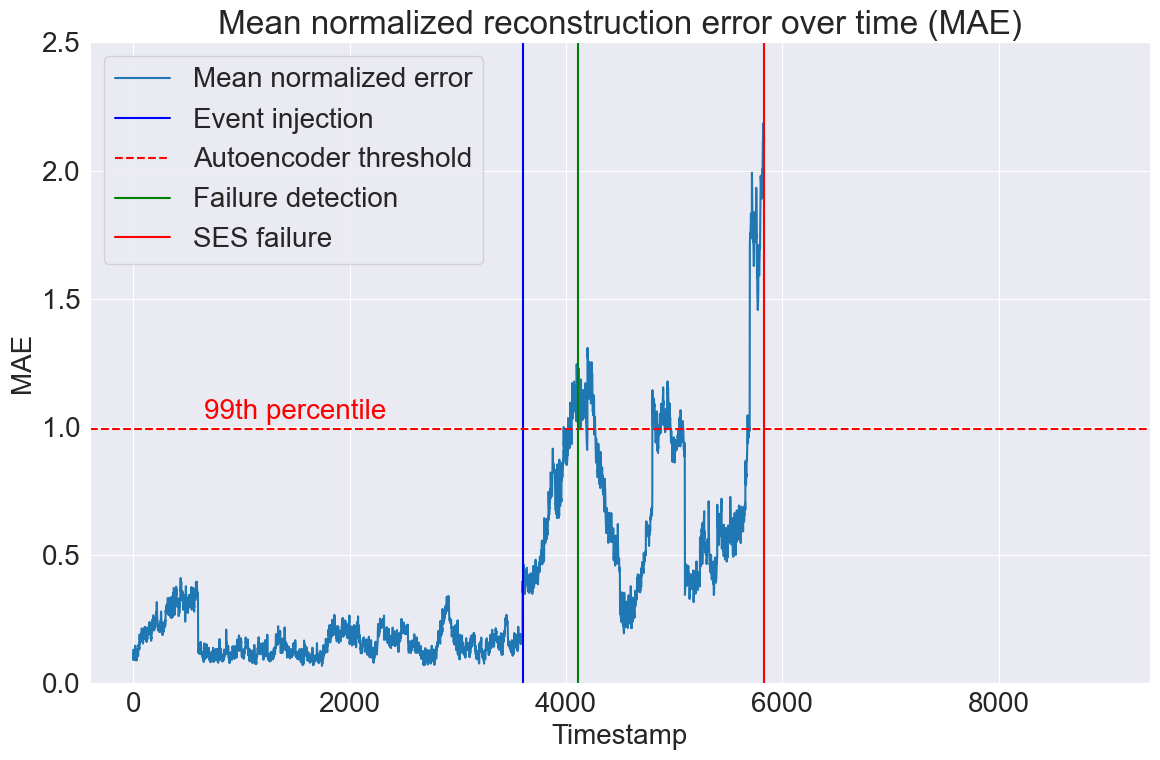

FAILURE DETECTED AT TIMESTAMP 4114, 514 seconds after injection and 1719 seconds before crash
Results saved to results/ directory


In [532]:
# Plot final results (MAE)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 20})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
detect_time = 60
confidence = 0.95

for indicator in mae_df.columns:
    errors = mae_df[indicator]
    errors_fail = mae_fail_df[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    #print(indicator + ': ' + str(max(normalized_errors)))
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/' + fail + '_' + hour + '_MAE_lstm.csv', index = False)

# Find timestamps where autoencoder error is > 0.99 for more consecutive timestamps
exceeding_timestamp = compute_failure(mean_normalized_errors['mean_error'], 0.99, detect_time, confidence)
if not exceeding_timestamp:
    try:
        anomaly_timestamp = mean_normalized_errors['mean_error'][mean_normalized_errors['mean_error'] > 0.99].idxmax()
    except:
        anomaly_timestamp = False

plt.figure()
if w_perc_99 != 0:
    x_range = np.arange(len(mean_normalized_errors['mean_error']))
    masked_normalized_errors = np.where(x_range <= w_perc_99, mean_normalized_errors['mean_error'], np.nan)
    plt.plot(x_range, masked_normalized_errors, label = 'Mean normalized error')
else:
    plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = 0.99, color = 'red', linestyle = '--', label = 'Autoencoder threshold')
if exceeding_timestamp:
    plt.axvline(x=exceeding_timestamp, color='green', linestyle='-', label='Failure detection')
    before = w_perc_99 - exceeding_timestamp
    after = exceeding_timestamp - 3600
else:
    if anomaly_timestamp:
        after = anomaly_timestamp - 3600

plt.annotate(f'99th percentile', xy = (1500, 1.03), xytext = (1500, 1.03),
             horizontalalignment = 'center', color = 'r')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
plt.ylim(0, 2.5)
plt.xlim(-400, 9400)
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='SES failure')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MAE_lstm.png', dpi = 300)
finish = time.perf_counter()
total_time += finish - start
plt.show()
if exceeding_timestamp:
    print(f"SES FAILURE DETECTED AT TIMESTAMP {exceeding_timestamp}, {after} seconds after injection and {before} seconds before crash")
elif anomaly_timestamp:
    print(f"SES ANOMALY DETECTED AT TIMESTAMP {anomaly_timestamp}, {after} seconds after injection (NO SES FAILURE)")
else:
    print(f"NO SES FAILURE/ANOMALY DETECTION")
print('Results saved to results/ directory')
plt.close()

In [ ]:
print('\nPREDICTOR execution time: ' + str(round(finish - start, 3)) + ' seconds\n')
print('Total execution time: ' + str(round(total_time, 3)) + ' seconds\n')